In [33]:
import numpy as np
import argparse
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.path import Path
from matplotlib.gridspec import GridSpec
from PIL import Image
import torch

from utils.read_dir import ReadDir
from utils.correspondece_constraint import *
from easydict import EasyDict as edict

from visualDet3D.utils.utils import cfg_from_file
from visualDet3D.networks.utils.registry import DETECTOR_DICT, DATASET_DICT
from visualDet3D.data.pipeline import build_augmentator

cfg = cfg_from_file("./config/config.py")

In [34]:
def compute_birdviewbox(line, shape, scale):
    npline = [np.float64(line[i]) for i in range(1, len(line))]
    h = npline[7] * scale
    w = npline[8] * scale
    l = npline[9] * scale
    x = npline[10] * scale
    y = npline[11] * scale
    z = npline[12] * scale
    rot_y = npline[13]

    print('line: name=%s truncated=%f occluded=%f alpha=%f\n bbox=[%f %f %f %f]\n dimensions=[%f %f %f]\n location=[%f %f %f]\n rotation_y=%f score=%f' % (line[0], npline[0], npline[1], npline[2], npline[3], npline[4], npline[5], npline[6], npline[7], npline[8], npline[9], npline[10], npline[11], npline[12], npline[13], npline[14]))

    R = np.array([[-np.cos(rot_y), np.sin(rot_y)],
                  [np.sin(rot_y), np.cos(rot_y)]])
    t = np.array([x, z]).reshape(1, 2).T

    x_corners = [0, l, l, 0]  # -l/2
    z_corners = [w, w, 0, 0]  # -w/2


    x_corners += -w / 2
    z_corners += -l / 2

    # bounding box in object coordinate
    corners_2D = np.array([x_corners, z_corners])
    # rotate
    corners_2D = R.dot(corners_2D)
    # translation
    corners_2D = t - corners_2D
    # in camera coordinate
    corners_2D[0] += int(shape/2)
    corners_2D = (corners_2D).astype(np.int16)
    corners_2D = corners_2D.T

    return np.vstack((corners_2D, corners_2D[0,:]))

def draw_birdeyes(ax2, line_gt, line_p, shape):
    # shape = 900
    scale = 15

    pred_corners_2d = compute_birdviewbox(line_p, shape, scale)
    #gt_corners_2d = compute_birdviewbox(line_gt, shape, scale)

    #codes = [Path.LINETO] * gt_corners_2d.shape[0]
    #codes[0] = Path.MOVETO
    #codes[-1] = Path.CLOSEPOLY
    #pth = Path(gt_corners_2d, codes)
    #p = patches.PathPatch(pth, fill=False, color='orange', label='ground truth')
    #ax2.add_patch(p)

    codes = [Path.LINETO] * pred_corners_2d.shape[0]
    codes[0] = Path.MOVETO
    codes[-1] = Path.CLOSEPOLY
    pth = Path(pred_corners_2d, codes)
    p = patches.PathPatch(pth, fill=False, color='green', label='prediction')
    ax2.add_patch(p)

def compute_3Dbox(P2, line):
    obj = detectionInfo(line)
    # Draw 2D Bounding Box
    xmin = int(obj.xmin)
    xmax = int(obj.xmax)
    ymin = int(obj.ymin)
    ymax = int(obj.ymax)
    # width = xmax - xmin
    # height = ymax - ymin
    # box_2d = patches.Rectangle((xmin, ymin), width, height, fill=False, color='red', linewidth='3')
    # ax.add_patch(box_2d)

    # Draw 3D Bounding Box

    R = np.array([[np.cos(obj.rot_global), 0, np.sin(obj.rot_global)],
                  [0, 1, 0],
                  [-np.sin(obj.rot_global), 0, np.cos(obj.rot_global)]])

    x_corners = [0, obj.l, obj.l, obj.l, obj.l, 0, 0, 0]  # -l/2
    y_corners = [0, 0, obj.h, obj.h, 0, 0, obj.h, obj.h]  # -h
    z_corners = [0, 0, 0, obj.w, obj.w, obj.w, obj.w, 0]  # -w/2

    x_corners = [i - obj.l / 2 for i in x_corners]
    y_corners = [i - obj.h for i in y_corners]
    z_corners = [i - obj.w / 2 for i in z_corners]

    corners_3D = np.array([x_corners, y_corners, z_corners])
    corners_3D = R.dot(corners_3D)
    corners_3D += np.array([obj.tx, obj.ty, obj.tz]).reshape((3, 1))

    corners_3D_1 = np.vstack((corners_3D, np.ones((corners_3D.shape[-1]))))
    corners_2D = P2.dot(corners_3D_1)
    corners_2D = corners_2D / corners_2D[2]
    corners_2D = corners_2D[:2]

    return corners_2D

def draw_3Dbox(ax, P2, line, color):

    corners_2D = compute_3Dbox(P2, line)

    # draw all lines through path
    # https://matplotlib.org/users/path_tutorial.html
    bb3d_lines_verts_idx = [0, 1, 2, 3, 4, 5, 6, 7, 0, 5, 4, 1, 2, 7, 6, 3]
    bb3d_on_2d_lines_verts = corners_2D[:, bb3d_lines_verts_idx]
    verts = bb3d_on_2d_lines_verts.T
    codes = [Path.LINETO] * verts.shape[0]
    codes[0] = Path.MOVETO
    # codes[-1] = Path.CLOSEPOLYq
    pth = Path(verts, codes)
    p = patches.PathPatch(pth, fill=False, color=color, linewidth=2)

    width = corners_2D[:, 3][0] - corners_2D[:, 1][0]
    height = corners_2D[:, 2][1] - corners_2D[:, 1][1]
    # put a mask on the front
    front_fill = patches.Rectangle((corners_2D[:, 1]), width, height, fill=True, color=color, alpha=0.4)
    ax.add_patch(p)
    ax.add_patch(front_fill)

In [42]:
def visualization(image_path, label_path, calib_path, pred_path,
                  dataset, VEHICLES, start_frame, end_frame):

    for index in range(start_frame, end_frame):
        image_file = os.path.join(image_path, dataset[index]+ '.png')
        #label_file = os.path.join(label_path, dataset[index] + '.txt')
        prediction_file = os.path.join(pred_path, dataset[index]+ '.txt')
        calibration_file = os.path.join(calib_path, dataset[index] + '.txt')
        for line in open(calibration_file):
            if 'P2' in line:
                P2 = line.split(' ')
                P2 = np.asarray([float(i) for i in P2[1:]])
                P2 = np.reshape(P2, (3, 4))


        fig = plt.figure(figsize=(20.00, 5.12), dpi=100)

        # fig.tight_layout()
        gs = GridSpec(1, 4)
        gs.update(wspace=0)  # set the spacing between axes.

        ax = fig.add_subplot(gs[0, :3])
        ax2 = fig.add_subplot(gs[0, 3:])

        # with writer.saving(fig, "kitti_30_20fps.mp4", dpi=100):
        image = Image.open(image_file).convert('RGB')
        shape = 900
        birdimage = np.zeros((shape, shape, 3), np.uint8)

        #with open(label_file) as f1, open(prediction_file) as f2:
        with open(prediction_file) as f2:
            #for line_gt, line_p in zip(f1, f2):
            for line_p in f2:
                #line_gt = line_gt.strip().split(' ')
                line_p = line_p.strip().split(' ')

                truncated = np.abs(float(line_p[1]))
                occluded = np.abs(float(line_p[2]))
                trunc_level = 255

            # truncated object in dataset is not observable
                if line_p[0] in VEHICLES  and truncated < trunc_level:
                    color = 'green'
                    if line_p[0] == 'Cyclist':
                        color = 'yellow'
                    elif line_p[0] == 'Pedestrian':
                        color = 'cyan'
                    draw_3Dbox(ax, P2, line_p, color)
                    draw_birdeyes(ax2, ['any'], line_p, shape)

        # visualize 3D bounding box
        ax.imshow(image)
        ax.set_xticks([]) #remove axis value
        ax.set_yticks([])

        # plot camera view range
        x1 = np.linspace(0, shape / 2)
        x2 = np.linspace(shape / 2, shape)
        ax2.plot(x1, shape / 2 - x1, ls='--', color='grey', linewidth=1, alpha=0.5)
        ax2.plot(x2, x2 - shape / 2, ls='--', color='grey', linewidth=1, alpha=0.5)
        ax2.plot(shape / 2, 0, marker='+', markersize=16, markeredgecolor='red')

        # visualize bird eye view
        ax2.imshow(birdimage, origin='lower')
        ax2.set_xticks([])
        ax2.set_yticks([])
        # add legend
        #handles, labels = ax2.get_legend_handles_labels()
        #legend = ax2.legend([handles[0], handles[1]], [labels[0], labels[1]], loc='lower right',
        #                    fontsize='x-small', framealpha=0.2)
        #for text in legend.get_texts():
        #    plt.setp(text, color='w')

        #print(dataset[index])
        plt.show()
        # video_writer.write(np.uint8(fig))



In [43]:
show_index = 0
show_at_same_time = 1

line: name=Car truncated=-1.000000 occluded=-1.000000 alpha=1.744867
 bbox=[673.745361 172.313156 724.518738 198.705109]
 dimensions=[1.381814 1.687014 4.051492]
 location=[4.960133 1.366875 40.359844]
 rotation_y=1.868669 score=0.990585


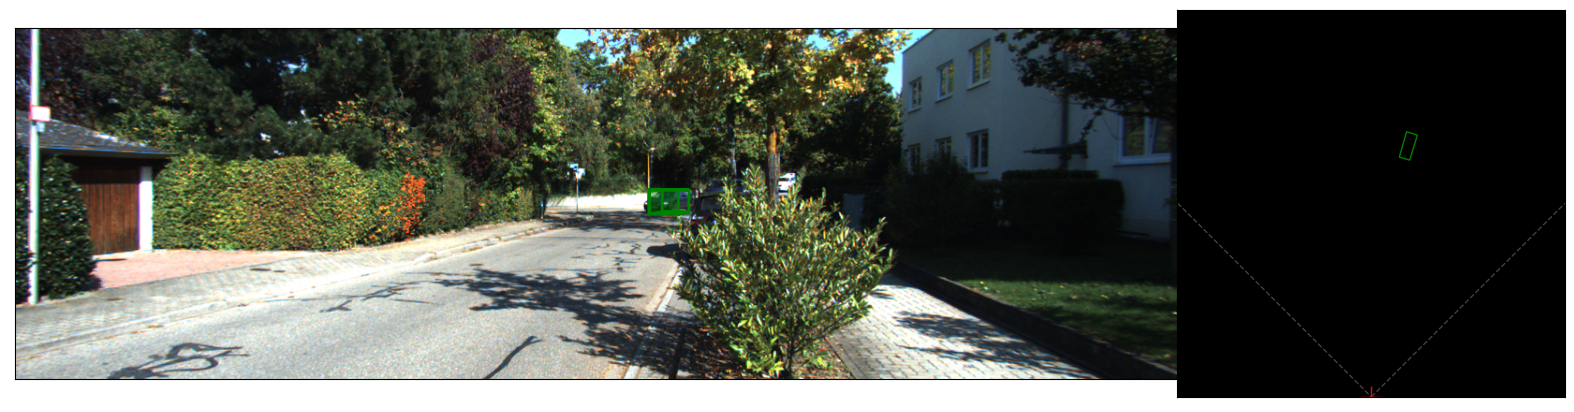

In [44]:
base_dir = './data/KITTI/object/testing'
#label_path = os.path.join()
image_path = os.path.join(base_dir, 'image_2')
calib_path = os.path.join(base_dir, 'calib')
pred_path = './workdirs/MonoDTR/output/test/data'

dataset = [name.split('.')[0] for name in sorted(os.listdir(image_path))]

VEHICLES = cfg.obj_types

visualization(image_path, 'any', calib_path, pred_path,
                dataset, VEHICLES, show_index, show_index+show_at_same_time)

show_index = show_index+1